Exercise 11 by Timo Marks

In [1]:
# Done by Timo Marks
import numpy as np
import matplotlib.pyplot as plt
subplot_keywords = {"xticks": [0,27], "yticks": [0,27]}

Get the spam E-Mail Data. Split Dataset into word occurence vector and class label vector (spam/not spam). Divide into training and test data.

In [2]:
with open("spambase.data", "r") as file:
    spamdata = [line.split(",") for line in file]
    spamdata = np.array(spamdata, dtype="float")

# the word occurence (0/1) -> columns 1:48
vecPosData = np.arange(0,47)
# the class-labels (0=not spam / 1=spam) -> column 57
vecPosLabel = 57

# 80% Train und 20% Test data
vecPosTrain = np.concatenate((np.arange(0,1450), np.arange(1813,4042)))
vecPosTest = np.concatenate((np.arange(1450,1813), np.arange(4042,4601)))

# extract word occurence data and transform to 0/1, noting that sign(x=0) = 0 and sign(x>0) = 1
# np.ix_(a,b) quickly construct index arrays that will index the cross product of a and b
matDataTrain = np.sign(spamdata[np.ix_(vecPosTrain, vecPosData)])
matDataTest = np.sign(spamdata[np.ix_(vecPosTest, vecPosData)])

# extract class labels
vecLabelTrain = spamdata[vecPosTrain, vecPosLabel]
vecLabelTest  = spamdata[vecPosTest,  vecPosLabel]

Training

In [3]:
# How often does the attribute (att=j) occur in a spam (1) mail across all spam mails
num_spam = np.sum(vecLabelTrain)
ones = np.ones(matDataTrain.shape[0])

num_spam_att = []
for attribute_column in matDataTrain.T:
    # Attribute occurs (1) AND it is spam mail (1)
    mask = np.asarray(attribute_column == ones) & (vecLabelTrain == ones)
    num_spam_att.append(np.sum(attribute_column[mask]))
# Probability over all attributes must sum up to 1
phi_att_spam = num_spam_att/np.sum(num_spam_att)

# How often does the attribute (att=j) occur in a non-spam (0) mail across all non-spam mails
num_non_spam = len(vecLabelTrain) - num_spam
zeros = np.zeros(matDataTrain.shape[0])

num_non_spam_att = []
for attribute_column in matDataTrain.T:
    # Attribute occurs (1) AND it is NOT spam mail (0)
    mask = np.asarray(attribute_column == ones) & (vecLabelTrain == zeros)
    num_non_spam_att.append(np.sum(attribute_column[mask]))
# Probability over all attributes must sum up to 1
phi_att_non_spam = num_non_spam_att/np.sum(num_non_spam_att)

# Number of Spam Mails devided by all mails
phi_spam = num_spam/(num_spam + num_non_spam)
print(f"Portion of Spam mails in Train Dataset is: {100*phi_spam:.2f}%")
print("The Documentation states 34.4%. For a good mix in the dataset, these should be relatively close.")


Portion of Spam mails in Train Dataset is: 39.41%
The Documentation states 34.4%. For a good mix in the dataset, these should be relatively close.


### Testing the algorithm
### $p(y=1|x) = \frac{p(x|y=1)p(y=1)}{p(x)} = \frac{\prod_{i=1}^n \phi_{i|y=1}\phi_y}{\prod_{i=1}^n \phi_{i|y=1} \phi_y+ \prod_{i=1}^n \phi_{i|y=0} (1-\phi_y)}$
$\phi_y = p(y=1) \Longrightarrow 1-\phi_y = p(y=0)$

In [4]:
# Input: One (row) vector of matDataTest that contains the sign (1/0) if the attribute is in the Mail.

# Probability matrix of mail x being spam or non-spam with these attributes
def naive_bayes(matData):
    prob_mat = np.empty((matData.shape[0],2))
    i=0
    for mail_att in matData:
        # Compute the phi products
        # The dtype=bool converts 1=True, 0=False. So we only multiply the probabilities of the attributes that occur
        mask = mail_att.astype(dtype=bool)
        prod_phi_att_spam = np.prod(phi_att_spam[mask])
        prod_phi_att_non_spam = np.prod(phi_att_non_spam[mask])

        # Compute probability that mail x with these attributes is spam or non-spam
        denominator = prod_phi_att_spam*phi_spam+prod_phi_att_non_spam*(1-phi_spam)
        prob_spam = (prod_phi_att_spam*phi_spam)/denominator
        prob_non_spam = (prod_phi_att_non_spam*(1-phi_spam))/denominator
        
        # Actually we do not need the denominator because we devide both probabilities by the denominator
        # Later we just look which probability is higher 
        # (and maybe by which percent higher than the other) to classify spam

        prob_mat[i,0] = prob_spam
        prob_mat[i,1] = prob_non_spam
        i += 1
    return prob_mat

Accuracy Functions

In [5]:
# We look whether the probability of Spam is higher than Non-Spam Mail (by some threshold)
# Threshold in "percent". Threshold = 1 means that it Spam prob. just needs to be higher than Non-Spam
# Threshold = 2 means that Spam prob. must be twice as high as Non-Spam to be classified as spam

def decide_if_spam(prob_mat, threshold):
    labeled_spam = np.zeros(prob_mat.shape[0])
    
    prob_spam_higher = prob_mat[:,0]/prob_mat[:,1]
    mask = np.asarray(prob_spam_higher >= threshold)
    labeled_spam[mask] += 1

    return labeled_spam

# Compute accuracy that the Mail is correctly classified as Spam/Non-Spam
def accuracy_overall(prob_mat_computed, true_label, threshold=1):
    labeled_spam = decide_if_spam(prob_mat_computed, threshold)
    accuracy = len(labeled_spam[labeled_spam == true_label])/len(true_label)
    return accuracy
    

# Testing the algorithm

In [6]:
# First we look if the algorithm is correctly implemented. If the threshold is 0, than ALL Mails are classified as spam
# So the accuracy should be the same as the number of Spam Mails in the Test dataset devided by all Mails in the Test dataset
prob_mat = naive_bayes(matDataTest)
print(f"Accuracy for threshold = 0 for Spam Mail: {100*accuracy_overall(prob_mat, vecLabelTest, 0):.4f}%")
print(f"Percentage of Spam Mails in Test Dataset: {100*np.sum(vecLabelTest)/len(vecLabelTest):.4f}%")
print("Should be equal")

Accuracy for threshold = 0 for Spam Mail: 39.3709%
Percentage of Spam Mails in Test Dataset: 39.3709%
Should be equal


Overall Accuracy that the Mail is correctly classified as Spam or Non-Spam

(0.0, 100.0)

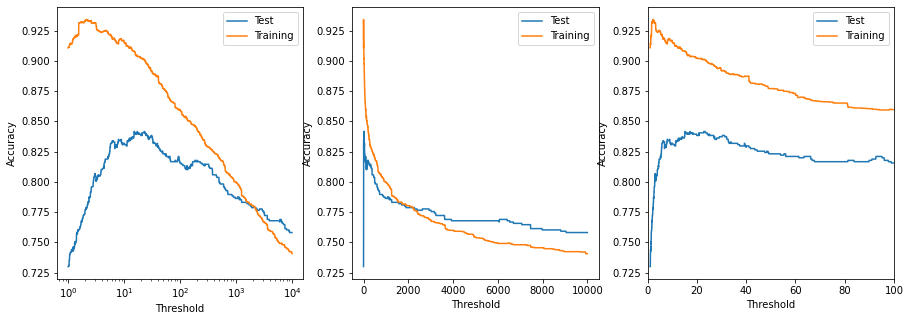

In [7]:
# Now we change the threshold. So threshold = 1 means, the probability for Spam is higher than Non-Spam.
# Threshold = 2 means the probability is twice as high for Spam than Non-Spam
n = 3

# We start at threshold = 10^0=1 until 10^4 because Spam classifier only makes sense if the probability of
# Spam is higher, so threshold is atleast 1.
fig, ax = plt.subplots(1,3, figsize=(15,5))
for (matData, vecLabel, label) in zip([matDataTest, matDataTrain], [vecLabelTest, vecLabelTrain], ["Test", "Training"]):
    accuracy_vec = []
    samples = 10000
    threshold_vec = np.logspace(0,4,samples)
    prob_mat = naive_bayes(matData)
    for t in threshold_vec:
        accuracy_vec.append(accuracy_overall(prob_mat, vecLabel, t))

    ax[0].semilogx(threshold_vec, accuracy_vec, label=label)
    ax[1].plot(threshold_vec, accuracy_vec, label=label)
    ax[2].plot(threshold_vec, accuracy_vec, label=label)

for i in np.arange(n):
    ax[i].set_xlabel("Threshold")
    ax[i].set_ylabel("Accuracy")
    ax[i].legend()
ax[2].set_xlim(0,100)

We can see, that the accuracy of classifing Spam gets higher if we require that the probability of "Spam" is around 10 times as high as "Non-Spam". Than we accuracy in the Test Data is around 84%. If we just say, that the probability for Spam is higher(threshold=1) than the accuracy is only around 73%. So we missclassify many more Mails as Spam and if the threshold is too high we missclassify many Spam-Mails as Non-Spam.  

Also we can see that the accuracy of the Training Data is much higher. This could indicate that the Training Data is not large enough or that words in a Spam Mail can differ much more, so that Test and Training Data is quite different.  